In [3]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        60
           1       0.78      0.81      0.79       140

    accuracy                           0.70       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.70      0.70      0.70       200

ROC-AUC: 0.759

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.41      0.43      0.42        60
           1       0.75      0.74      0.74       140

    accuracy                           0.65       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.65      0.65      0.65       200

ROC-AUC: 0.585

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.61      0.45      0.52        60
           1       0.79      0.88      0.83       140

    accuracy                           0.75       200
   macro avg       0.70

C:\Users\SURENDRA\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [06:01:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        60
           1       0.78      0.85      0.82       140

    accuracy                           0.73       200
   macro avg       0.67      0.65      0.66       200
weighted avg       0.72      0.73      0.72       200

ROC-AUC: 0.745

Model Comparison:
                  Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression     0.705   0.775510  0.814286  0.759405
1        Decision Tree     0.645   0.751825  0.735714  0.584524
2        Random Forest     0.750   0.788462  0.878571  0.782202
3              XGBoost     0.730   0.782895  0.850000  0.745119


C:\Users\SURENDRA\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [06:01:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


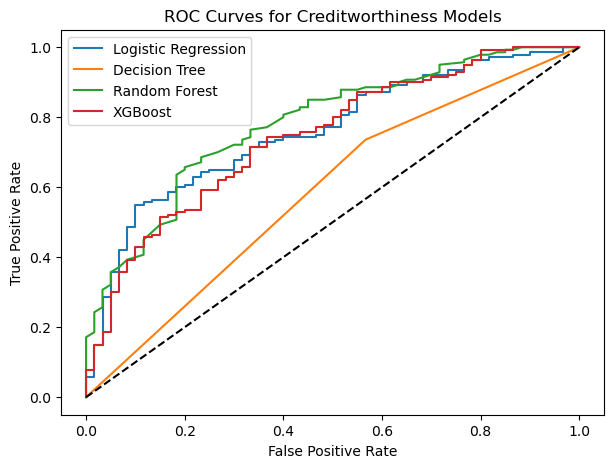

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

data = fetch_openml("credit-g", version=1, as_frame=True)
df = data.frame
X = df.drop("class", axis=1)
y = df["class"].map({"good": 1, "bad": 0})  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
}


results = []

for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor),
                          ("classifier", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, roc])
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc:.3f}")


results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "ROC-AUC"])
print("\nModel Comparison:\n", results_df)


plt.figure(figsize=(7, 5))
for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor),
                          ("classifier", model)])
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Creditworthiness Models")
plt.legend()
plt.show()
